<a href="https://colab.research.google.com/github/d-roland/toxicityDetection/blob/main/CS224n_Toxicity_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import csv
from collections import Counter, defaultdict
from wordcloud import WordCloud
import string
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
import gensim
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, CuDNNLSTM, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from datetime import datetime
from statistics import mean
import random
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [5]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

### Loading and merging datasets

In [6]:
colnames=['Sentence', 'Type', 'Level', 'Target'] 
hateful = pd.read_csv('/content/drive/My Drive/CS224n_Project/Hatefuls.csv', names=colnames, header=None)
hateful.shape

(194593, 4)

In [7]:
hateful.describe()

,Sentence,Type,Level,Target
count,194572,194593,194593,194593
unique,63324,14,4,6
top,tg,Insult,VERY_HIGH,USER
freq,1364,116947,66901,96997


In [8]:
#Adding a class column prior to merging with neutral data
hateful["Class"] = 1
hateful.head()

,Sentence,Type,Level,Target,Class
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1
3,T un kiko mdr,Insult,LOW,USER,1
4,Moi mdr t trop nul,Hate,LOW,USER,1


In [9]:
hateful.Sentence = hateful.Sentence.astype(str)

In [10]:
neutral = pd.read_csv('/content/drive/My Drive/CS224n_Project/Neutrals_200k.csv', names=colnames, header=None)
neutral.shape

(200000, 4)

In [11]:
neutral.Sentence = neutral.Sentence.astype(str)

In [12]:
#Adding a class column prior to merging with toxic data
neutral["Class"] = 0
neutral.head()

,Sentence,Type,Level,Target,Class
0,"Chui désolé, mais quand un film de science-fic...",Neutral,NONE,UNDEFINED,0
1,Mdrrr junior bvndo,Neutral,NONE,UNDEFINED,0
2,baham je taimz,Neutral,NONE,UNDEFINED,0
3,Meilleurs rappeurs de tout les temps 😂😂😂 je ri...,Neutral,NONE,UNDEFINED,0
4,7up❤️,Neutral,NONE,UNDEFINED,0


In [13]:
dataset = hateful.append([neutral], ignore_index=True)
dataset.shape

(394593, 5)

In [14]:
dataset.head()

,Sentence,Type,Level,Target,Class
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1
3,T un kiko mdr,Insult,LOW,USER,1
4,Moi mdr t trop nul,Hate,LOW,USER,1


In [15]:
dataset.tail()

,Sentence,Type,Level,Target,Class
394588,@studiosushi @Chitori_Bocchi evangelionnnnnnnn...,Neutral,NONE,UNDEFINED,0
394589,J'ai kiffer les 2 Baby sitter c drôle et horri...,Neutral,NONE,UNDEFINED,0
394590,Moi aussi je t'ai demandé si tu étais la premi...,Neutral,NONE,UNDEFINED,0
394591,venez on fait l' aphalbet,Neutral,NONE,UNDEFINED,0
394592,Bah oui 80% de la police france est pro RN ...,Neutral,NONE,UNDEFINED,0


### Analyzing dataset

In [16]:
dataset.groupby(['Target']).count()

,Sentence,Type,Level,Class
Target,,,,
AUTHOR_OF_COMMENT,2547,2547,2547,2547
EVERYONE,16603,16603,16603,16603
GROUP,36083,36083,36083,36083
NO_ONE,1,1,1,1
SINGLE_PERSON,36128,36128,36128,36128
UNDEFINED,199191,199191,199191,199191
USER,97574,97574,97574,97574
USER_FAMILY,6466,6466,6466,6466


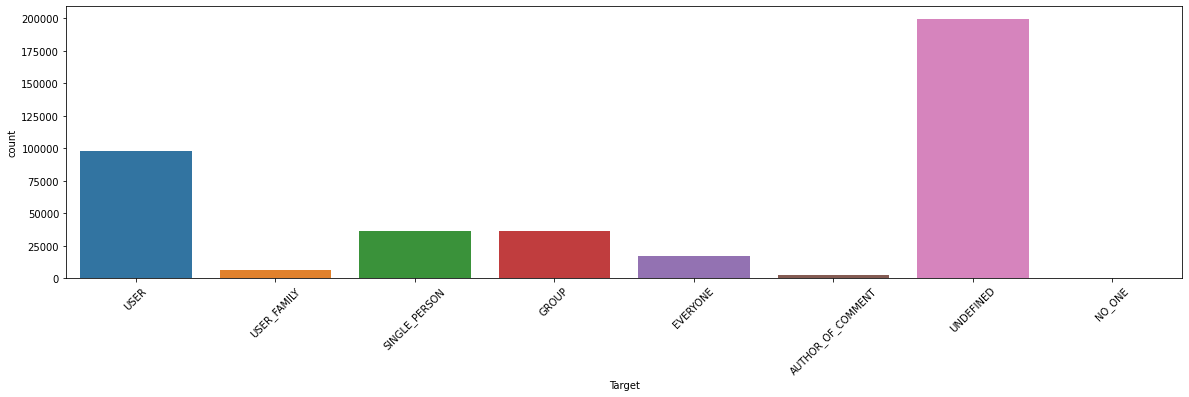

In [17]:
plt.figure(figsize=(20,5))
chart = sns.countplot("Target", data=dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [18]:
dataset.groupby(['Type']).count()

,Sentence,Level,Target,Class
Type,,,,
Ads,27,27,27,27
Critics,15,15,15,15
Hate,37293,37293,37293,37293
Homophobia,12256,12256,12256,12256
Insult,116947,116947,116947,116947
Misogyny,6,6,6,6
Mockery,13950,13950,13950,13950
Moral Harassment,1583,1583,1583,1583
Neutral,200009,200009,200009,200009


In [19]:
dataset.groupby(['Level']).count()

,Sentence,Type,Target,Class
Level,,,,
HIGH,53358,53358,53358,53358
LOW,28016,28016,28016,28016
MEDIUM,46880,46880,46880,46880
NONE,199189,199189,199189,199189
VERY_HIGH,67150,67150,67150,67150


In [20]:
dataset_stats = dataset.groupby(['Target', 'Level']).size().reset_index(name='count')
pd.pivot_table(dataset_stats, index=['Level'], columns = ['Target'],values=['count'], fill_value=0)

count                 ...                             
Target    AUTHOR_OF_COMMENT EVERYONE GROUP  ... UNDEFINED   USER USER_FAMILY
Level                                       ...                             
HIGH                    189     3952  9004  ...         4  27624        3577
LOW                    1350     2743  9031  ...         1   5481         378
MEDIUM                  837     2125  9036  ...        14  24422        1413
NONE                      0        4     0  ...    199171     13           0
VERY_HIGH               171     7779  9012  ...         1  40034        1098

[5 rows x 8 columns]

In [21]:
#Checking if empty Sentences exist
empty_index = [index for index,text in enumerate(dataset.Sentence.values) if str(text).strip() == '']
print("No of empty rows: {}".format(len(empty_index)))
hateful.iloc[empty_index].tail()

No of empty rows: 0


,Sentence,Type,Level,Target,Class


In [22]:
#Checking frequent words
cnt = Counter()
for text in dataset["Sentence"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('de', 212725),
 ('la', 117593),
 ('et', 104727),
 ('le', 99444),
 ('les', 94956),
 ('pas', 85171),
 ('que', 81618),
 ('des', 72996),
 ('à', 66654),
 ('un', 63619),
 ('a', 58883),
 ('je', 58172),
 ('pour', 57210),
 ('en', 56610),
 ('qui', 55488),
 ('est', 54054),
 ('tu', 51424),
 ('vous', 42380),
 ('une', 41758),
 ('il', 39910)]

In [23]:
#Checking average sentence length vs toxicity level
dataset['Length'] = dataset['Sentence'].apply(len)
#fig,(ax1, ax2) = plt.subplots(1,2)
#sns.barplot('Level','Length',data = dataset,palette='PRGn',ax=ax1).set_title('Avg Sentence Length vs Level')
#sns.barplot('Target','Length',data = dataset,palette='PRGn',ax=ax2).set_title('Avg Sentence Length vs Target')
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
#plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
#fig.tight_layout()

In [24]:
#Checking average word number vs toxicity level
dataset['Count'] = dataset['Sentence'].str.split().str.len()
#fig,(ax1, ax2) = plt.subplots(1,2)
#sns.barplot('Level','Count',data = dataset,palette='PRGn',ax=ax1).set_title('Average Word Count vs Level')
#sns.barplot('Target','Count',data = dataset,palette='PRGn',ax=ax2).set_title('Average Word Count vs Target')
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
#plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
#fig.tight_layout()

### Cleaning dataset

In [25]:
#Lowering all sentences

dataset['cleanSentence'] = dataset['Sentence'].apply(lambda x: x.lower())
dataset.head()

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo 😂😂🥃
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t’es vilain 😂😂😂😂😂😂
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d'île je m'abonne à ta chaine...
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul


In [31]:
#Dealing with emojis
!pip install emoji
import emoji

#does the text contain an emoji?
def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI["en"]:
            return True
    return False

#extract emojis for possible future use
def extract_emoji(text):
    emoji_list = []
    data = re.findall(r'[^\w\s,]', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI["en"] for char in word):
            emoji_list.append(word)
    return emoji_list

#remove the emoji
def remove_emoji(text):
  data = re.findall(r'[^\w\s,]', text)
  for word in data:
      if any(char in emoji.UNICODE_EMOJI["en"] for char in word):
          text = text.replace(word, '')
  return text

# Checking if emoji in source Sentence
dataset['Emoji'] = dataset['Sentence'].apply(extract_emoji)

# Removing Emojis from Sentence
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_emoji)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t’es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d'île je m'abonne à ta chaine...,[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[]
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂]
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[]
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c'est quoi cette mode ou presque tout les yout...,[]
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,@vittoremorgane @crdsar et ? il est au dessus ...,[]


In [84]:
#ALTERNATIVE: convert emojis to corresponding text (to keep their spirit)
# TODO

In [32]:
#Special characters cleaning
"""
A utility function to remove numerical characters from the text.

"""

def remove_nums(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text


"""
A utility function to remove URL links from the text.

"""

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove HTML tags from the text.

"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


"""
A utility function to remove @

"""

def remove_special(text):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^ \nA-Za-z0-9À-ÖØ-öø-ÿ/ \t])", " ",text).split())
#    return " ".join(re.sub("(@[^\s]+)", " ",text).split())


#dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_nums)
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_URL)
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_html)
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_special)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[]
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂]
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[]
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[]
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[]


In [33]:
#Removing punctuation
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")

def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_punctuations)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[]
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂]
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[]
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[]
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[]


In [34]:
#Checking frequent words
cnt = Counter()
for text in dataset["cleanSentence"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('de', 219669),
 ('est', 133579),
 ('la', 130992),
 ('et', 120552),
 ('le', 113016),
 ('les', 106419),
 ('c', 95209),
 ('pas', 92356),
 ('que', 84686),
 ('je', 80306),
 ('des', 77276),
 ('a', 76027),
 ('un', 75793),
 ('en', 73365),
 ('à', 70458),
 ('il', 67933),
 ('tu', 65680),
 ('pour', 61827),
 ('qui', 58492),
 ('l', 55957)]

In [35]:
#Removing stopwords
STOPWORDS = nltk.corpus.stopwords.words('french')
#STOPWORDS = set(nltk.corpus.stopwords.words('english')) | set(nltk.corpus.stopwords.words('french'))

dataset_wo_stop = dataset.copy()

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

dataset_wo_stop['cleanSentence'] = dataset_wo_stop['cleanSentence'].apply(remove_stopwords)
dataset_wo_stop.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,bo,"[😂, 😂, 🥃]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,vilain,"[😂, 😂, 😂, 😂, 😂, 😂]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,propose île abonne chaine abonner chaîne youtu...,[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,kiko mdr,[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,mdr trop nul,[]
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,mono sourcils,[😂]
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[]
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode presque tout youtubeurs joue j...,[]
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,dessus lois fais reunions travail tous jours v...,[]


### Tokenizing

#### Word tokens

In [36]:
dataset['finalSentence'] = dataset['cleanSentence'].apply(word_tokenize)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,finalSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]","[t, pas, bo]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]","[t, es, vilain]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],"[je, te, propose, un, d, île, je, m, abonne, à..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],"[t, un, kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],"[moi, mdr, t, trop, nul]"
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂],"[ta, un, mono, sourcils]"
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],"[grosse, merdes]"
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]","[espèce, de, gamin]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[],"[c, est, quoi, cette, mode, ou, presque, tout,..."
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[],"[et, il, est, au, dessus, des, lois, je, fais,..."


#### Keras tokens

In [37]:
#Tokenizing Text with Keras -> Representing each word by a number
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(dataset["finalSentence"])

X_tok = tokenizer.texts_to_sequences(dataset["finalSentence"])


In [38]:
X_tok[0][:10]

[29, 8, 5523]

In [39]:
#Lets check few word to numerical representation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print("{} -> {}".format(word, num))
    if num == 10:
        break        

de -> 1
est -> 2
la -> 3
et -> 4
le -> 5
les -> 6
c -> 7
pas -> 8
que -> 9
je -> 10


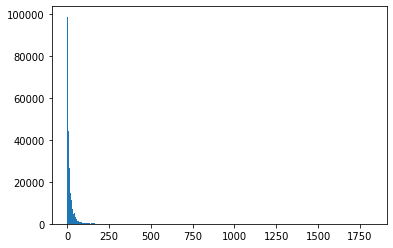

In [40]:
# Making histogram for no of words in sentences shows that most news sentences are under 150 words.
plt.hist([len(x) for x in X_tok], bins=500)
plt.show()

In [41]:
#Lets keep all sentences to 150, add padding to news with less than 150 words and truncating long ones
maxlen = 150 

#Making all news of size maxlen defined above, padding with 0 when needed
X_tok = pad_sequences(X_tok, maxlen=maxlen)

In [42]:
# Embedding Layer used in Keras creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [43]:
y = dataset["Level"]

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
print(y)

0          LOW
1          LOW
2          LOW
3          LOW
4          LOW
          ... 
394588    NONE
394589    NONE
394590    NONE
394591    NONE
394592    NONE
Name: Level, Length: 394593, dtype: object


In [44]:
labels_mapping = dict(zip(encoder.classes_,encoder.transform(encoder.classes_)))
labels_mapping

{'HIGH': 0, 'LOW': 1, 'MEDIUM': 2, 'NONE': 3, 'VERY_HIGH': 4}

In [45]:
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

In [46]:
X_train_tok, X_test_tok, y_train_tok, y_test_tok = train_test_split(X_tok, dummy_y, test_size = 0.2) 

### Creating final datasets

In [ ]:
#Keeping only 60k neutral examples

remove_n = len(dataset[dataset.Class == 0]) - 60000
neutralIndices = dataset[dataset.Class == 0].index
drop_indices = np.random.choice(neutralIndices, remove_n)
short_dataset = dataset.drop(index = drop_indices)
short_dataset

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,finalSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]","[t, pas, bo]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,tes vilain,"[😂, 😂, 😂, 😂, 😂, 😂]","[tes, vilain]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d le je m abonne ta chaine et...,[],"[je, te, propose, un, d, le, je, m, abonne, ta..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],"[t, un, kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],"[moi, mdr, t, trop, nul]"
...,...,...,...,...,...,...,...,...,...,...
394581,Puis le divorce n était pas accecible comme au...,Neutral,NONE,UNDEFINED,0,677,132,puis le divorce n tait pas accecible comme auj...,[],"[puis, le, divorce, n, tait, pas, accecible, c..."
394584,@franceinfo Elle en sait quelque chose @nadine...,Neutral,NONE,UNDEFINED,0,58,8,elle en sait quelque chose morano,"[🤭, 😁, 😁]","[elle, en, sait, quelque, chose, morano]"
394587,@NicolasCatard @IntelFrance le mien il a deja ...,Neutral,NONE,UNDEFINED,0,109,17,le mien il a deja 4 ans je participe avec plai...,[],"[le, mien, il, a, deja, 4, ans, je, participe,..."
394588,@studiosushi @Chitori_Bocchi evangelionnnnnnnn...,Neutral,NONE,UNDEFINED,0,67,3,bocchi evangelionnnnnnnnnnnnnnnnnnnnnnnnnnnnn,[],"[bocchi, evangelionnnnnnnnnnnnnnnnnnnnnnnnnnnnn]"


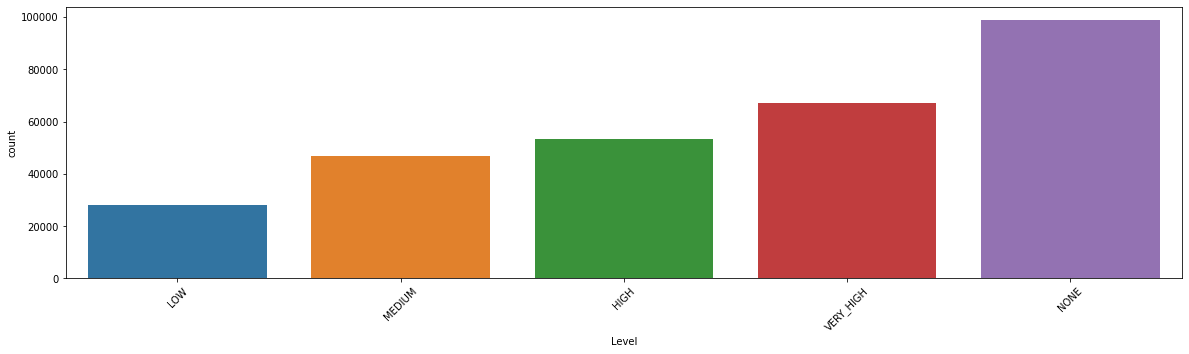

In [ ]:
plt.figure(figsize=(20,5))
chart = sns.countplot("Level", data=short_dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [ ]:
simpleDataset = short_dataset[['cleanSentence', 'Level']].copy()
simpleDataset.head()

,cleanSentence,Level
0,t pas bo,LOW
1,tes vilain,LOW
2,je te propose un d le je m abonne ta chaine et...,LOW
3,t un kiko mdr,LOW
4,moi mdr t trop nul,LOW


In [ ]:
simpleTrain, simpleTest = train_test_split(simpleDataset, test_size=0.2)
print(simpleTrain.shape, simpleTest.shape)

(235166, 2) (58792, 2)


# Vectorization

In [47]:
EMBEDDING_DIM = 200

In [48]:
# Function to create weight matrix between word-index and vectors from gensim models
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        try: 
          weight_matrix[i] = model[word]
        except:
          pass
    return weight_matrix

### Via TF-IDF

In [ ]:
X_simpleTrain = simpleTrain['cleanSentence'].to_numpy()
y_simpleTrain = simpleTrain['Level'].to_numpy()

X_simpleTest = simpleTest['cleanSentence'].to_numpy()
y_simpleTest = simpleTest['Level'].to_numpy()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_simpleTrain_tfidf = vectorizer.fit_transform(X_simpleTrain)
X_simpleTest_tfidf = vectorizer.transform(X_simpleTest)

In [ ]:
X_simpleTrain_tfidf.shape

(235371, 88162)

In [ ]:
X_simpleTrain[:10]

array(['une chvre mme le pen ferait mieux',
       'euphmisme heureusement que des initiatives d interpellation de fr sont menes mukwege drmukwege',
       'dj il faut tre fire de ce que vous tes et ne pas dire femme de couleur mais femme noire tout simplement',
       'rponse rapide finance123loans com vous tes a la recherche de prt pour soit relancer vos activits soit pour la ralisation d un projet soit pour vous achetez un appartement mais hlas la banque vous pose assez de conditions dont vous tes incapables plus de soucis je mets la disposition de tout dsirants des crdits personnels allant de 2000 jusqu 10 000 000 avec un taux d intrt allant de 3 en fonction du montant demand veuillez nous prciser dans votre demande de prt le montant exact et la dure de remboursement que vous souhaiteriez pour que je puisse vous satisfaire avec prcision et le plus rapidement possible',
       'petit con', 'c une michto ta copine',
       'automode la con de ta mre arrte toi', 'niquer tous vos grand

In [ ]:
y_simpleTrain[:10]

array(['HIGH', 'NONE', 'MEDIUM', 'HIGH', 'NONE', 'HIGH', 'HIGH',
       'VERY_HIGH', 'MEDIUM', 'HIGH'], dtype=object)

### Via FastText

In [50]:
fasttext_model = gensim.models.FastText(sentences=dataset["finalSentence"], size=EMBEDDING_DIM, window=5, min_count=5)

In [51]:
len(fasttext_model.wv.vocab)

36297

In [52]:
fasttext_model.wv["merde"]

array([ 1.28277254e+00,  2.37815356e+00,  5.41421592e-01, -3.97268504e-01,
        3.64808589e-01, -1.97345388e+00, -1.30945504e+00,  4.55946982e-01,
        1.97585416e+00,  2.32089579e-01,  2.41845608e+00,  7.88552165e-01,
        1.46034014e+00,  1.19476938e+00,  1.39157438e+00,  1.28285086e+00,
        9.52229381e-01,  2.74617076e-01, -2.01065958e-01,  4.26023394e-01,
        1.87982190e+00, -9.90394175e-01, -3.32589436e+00,  2.06895304e+00,
        1.99276078e+00, -7.38700986e-01, -8.75100851e-01, -2.62912917e+00,
       -1.14301793e-01,  1.55689871e+00,  8.96778464e-01, -1.54684866e-02,
        1.72944307e+00,  1.80163562e+00,  1.98262596e+00,  2.38149866e-01,
        1.22910571e+00,  1.63723499e-01, -5.27954221e-01, -3.71727490e+00,
       -1.38495553e+00, -7.82626450e-01,  1.65324569e+00, -4.36282009e-02,
       -6.67426288e-01,  1.63421437e-01, -1.21430421e+00, -6.31466985e-01,
       -1.91856551e+00,  3.34578156e-01, -3.95928645e+00, -8.34798038e-01,
        6.91828579e-02,  

In [53]:
print(fasttext_model.wv.most_similar("merde"))

[('merdebfmmerde', 0.9705947637557983), ('merdeee', 0.9597932696342468), ('dmerde', 0.9513048529624939), ('bfmerde', 0.9463177919387817), ('merdeeee', 0.9382055997848511), ('lamerde', 0.9356496930122375), ('merdeu', 0.9343056082725525), ('emerde', 0.9300199747085571), ('merddd', 0.926791787147522), ('merd', 0.9161005020141602)]


In [54]:
ft_embedding_vectors = get_weight_matrix(fasttext_model, word_index)

### Via Word2Vec

In [49]:
w2v_model = gensim.models.Word2Vec(sentences=dataset["finalSentence"], size=EMBEDDING_DIM, window=5, min_count=5)

In [50]:
len(w2v_model.wv.vocab)

36605

In [51]:
w2v_model["merde"]

array([-0.44167414, -0.57466024,  1.3229734 , -0.8138429 ,  0.7389031 ,
       -1.046623  ,  2.1426883 , -0.47184685,  1.4757396 , -2.4019508 ,
       -1.8502212 , -0.9009774 ,  2.3653831 , -1.403554  ,  1.5912931 ,
       -1.3716445 ,  2.4951086 ,  1.2120715 , -0.08946671,  0.01827973,
        0.29409784, -1.9760131 ,  0.22887214,  0.7250679 ,  0.5397885 ,
       -0.64699244, -2.2272108 , -0.1081611 , -1.7487895 ,  0.85025674,
        0.916776  ,  1.964579  , -1.6468168 , -1.2373204 ,  1.0139377 ,
       -0.23523009, -1.1258075 ,  1.5997359 ,  2.1710234 ,  0.6162649 ,
       -0.92634887,  3.0964432 , -2.2388763 ,  0.79962194, -0.01949489,
       -1.2615734 , -1.1920958 , -0.8548928 ,  0.39548522, -2.2880988 ,
        2.547163  ,  1.7059351 ,  1.0158545 , -0.21936503, -2.611934  ,
       -0.07522841, -0.08792974,  1.9504817 ,  2.428722  , -0.42266917,
        1.957506  , -1.2184954 ,  1.8075904 , -0.78605986, -0.31870306,
        0.481328  , -2.6158316 , -0.02298287, -0.57275474, -0.14

In [52]:
print(w2v_model.wv.most_similar("merde"))

[('mrd', 0.5406033992767334), ('merdes', 0.5210213661193848), ('daube', 0.5146381258964539), ('vermine', 0.4651830792427063), ('merd', 0.4461911916732788), ('faute', 0.4217475652694702), ('bouse', 0.41559603810310364), ('chimio', 0.4036428928375244), ('m3rde', 0.3944900929927826), ('racaille', 0.3916143774986267)]


In [53]:
w2v_embedding_vectors = get_weight_matrix(w2v_model, word_index)

### Via FastText Pretrained vectors

In [ ]:
!pip install fasttext

In [ ]:
import fasttext.util
fasttext.util.download_model('fr', if_exists='ignore')
ft = fasttext.load_model('cc.fr.300.bin')

In [ ]:
ft.get_dimension()

In [ ]:
#Optional - reduce vectors dimensions
#fasttext.util.reduce_model(ft, 100)
#ft.get_dimension()

In [ ]:
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz

### Via Universal Sentence Encoder

# Modelization

## Baseline - Prediction based on sentence only

### Via SVM (Baseline)

In [ ]:
from sklearn.svm import SVC

linear_svm_classifier_tfidf = SVC(kernel = "linear").fit(X_simpleTrain_tfidf,y_simpleTrain)

In [ ]:
train_acc_svm = metrics.accuracy_score(y_simpleTrain, linear_svm_classifier_tfidf.predict(X_simpleTrain_tfidf))
print("Training accuracy: ", train_acc_svm)

In [ ]:
predictions_svm_tfidf = linear_svm_classifier_tfidf.predict(X_simpleTest_tfidf)
print(predictions_svm_tfidf)

In [ ]:
print(classification_report(y_simpleTest, predictions_svm_tfidf))

### Via Perspective API

### Via FastText

In [ ]:
label_mapping = {'NONE': '__label__0',
                     'LOW': '__label__1',
                     'MEDIUM': '__label__2',
                     'HIGH': '__label__3',
                     'VERY_HIGH': '__label__4'}

In [ ]:
#np.savetxt(r'Model_training_data.txt', dataset.values, fmt='%d')

In [ ]:
#model = fasttext.train_supervised(input=train_fn,
#                                  pretrainedVectors=pretrainedvec_fn,
#                                  dim=300, 
#                                  wordNgrams=2, 
#                                  minCount=3, 
#                                  epoch=20, 
#                                  loss='ova')

### Via Bi-LSTM

In [54]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
#lstm_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
#Bi-LSTM
lstm_model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
lstm_model.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_model.add(Dense(5, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [55]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 200)          26505600  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense (Dense)                (None, 200)               51400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total params: 26,894,901
Trainable params: 389,301
Non-trainable params: 26,505,600
_________________________________________________________________


In [ ]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_tok, y_train_tok, validation_split=0.2, epochs=4, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 252539 samples, validate on 63135 samples
Epoch 1/4
252539/252539 [==============================] - 2944s 12ms/sample - loss: 0.7124 - acc: 0.7486 - val_loss: 0.5740 - val_acc: 0.7992
Epoch 2/4
252539/252539 [==============================] - 2949s 12ms/sample - loss: 0.5649 - acc: 0.8035 - val_loss: 0.5072 - val_acc: 0.8272
Epoch 3/4
216800/252539 [========================>.....] - ETA: 6:42 - loss: 0.5143 - acc: 0.8220

In [ ]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
lstm_pred = (lstm_model.predict(X_test_tok) >= 0.5).astype("int")

In [ ]:
print(classification_report(y_test_tok, lstm_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), lstm_pred.argmax(axis=1))
print(conf_matrix)

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

### Via CamemBERT

==> https://www.kaggle.com/houssemayed/camembert-for-french-tweets-classification

In [ ]:
!pip install transformers
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import AdamW
import torch

MAX_LEN = 128

# Initialize CamemBERT tokenizer
cam_tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

# Creates list of texts and labels
text = dataset['cleanSentence'].to_list()
labels = dataset['Level'].to_list()

#user tokenizer to convert sentences into tokenizer
input_ids  = [cam_tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN) for sent in text]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]  
    attention_masks.append(seq_mask)


## Next stage - Prediction based on sentence + target

### Via Perspective API

### Via FastText

### Via Bi-LSTM

### Via CamemBERT

# Target prediction

### By training a classifier based on current "Target" label?

### Via semantic role labeling ?

### Via lexical features analysis ?

### Via modified Aspect-Based Sentiment Analysis ?

# Data augmentation

### Via Google Translate